In [1]:
import os
data_folder = "cifar-10-batches-py/"
batch1_filename = os.path.join(data_folder, "data_batch_1")

In [2]:
import pickle
def unpickle(filename):
    with open(filename, 'rb') as fo:
        return pickle.load(fo, encoding='latin1')

In [3]:
batch1 = unpickle(batch1_filename)

In [4]:
image_index = 100
image = batch1['data'][image_index]

In [5]:
image = image.reshape((32,32, 3), order='F')
import numpy as np
image = np.rot90(image, -1)

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt

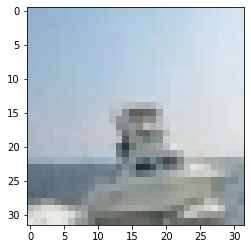

In [7]:
plt.imshow(image)

In [8]:
import theano
from theano import tensor as T

In [9]:
a = T.dscalar()
b = T.dscalar()

In [10]:
c = T.sqrt(a ** 2 + b ** 2)

In [11]:
f = theano.function([a,b], c)

In [12]:
f(3,4)

array(5.)

In [13]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data.astype(np.float32)
y_true = iris.target.astype(np.int32)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_true, random_state=14)

In [15]:
import lasagne
input_val = T.fmatrix("inputs")
target_val = T.ivector("targets")

In [16]:
input_layer = lasagne.layers.InputLayer(shape=X_train.shape, input_var=input_val)

In [17]:
hidden_layer = lasagne.layers.DenseLayer(input_layer, num_units=12, nonlinearity=lasagne.nonlinearities.sigmoid)

In [18]:
output_layer = lasagne.layers.DenseLayer(hidden_layer, num_units=3, nonlinearity=lasagne.nonlinearities.softmax)

In [19]:
output_val = lasagne.layers.get_output(output_layer)

In [20]:
loss = lasagne.objectives.categorical_crossentropy(output_val, target_val)
loss = loss.mean()

In [21]:
all_params = lasagne.layers.get_all_params(output_layer, trainable=True)
updates = lasagne.updates.sgd(loss, all_params, learning_rate=0.1)

In [22]:
train = theano.function([input_val, target_val], loss, updates=updates, allow_input_downcast=True)

In [23]:
get_output = theano.function([input_val], output_val)

In [24]:
for n in range(1000):
    train(X_train, y_train)

In [25]:
y_output = get_output(X_test)

In [26]:
y_pred = np.argmax(y_output, axis=1)

In [27]:
print(y_pred)

[0 0 0 1 2 1 0 1 0 1 2 0 2 2 0 1 0 2 2 1 0 0 0 1 0 2 0 1 1 0 0 1 1 0 1 0 2
 1]


In [28]:
from sklearn.metrics import f1_score
print(f1_score(y_test, y_pred, average='micro'))

1.0


In [29]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from skimage.transform import resize
from skimage import transform as tf
from skimage.measure import label, regionprops
from sklearn.utils import check_random_state
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [30]:
def create_captcha(text, shear=0, size=(100,24)):
    im = Image.new("L", size, "black")
    draw = ImageDraw.Draw(im)
    font = ImageFont.truetype(r"Coval.otf", 22)
    draw.text((2, 2), text, fill=1, font=font)
    image = np.array(im)
    affine_tf = tf.AffineTransform(shear=shear)
    image = tf.warp(image, affine_tf)
    return image / image.max()

In [31]:
def segment_image(image):
    labeled_image = label(image > 0)
    subimages = []
    for region in regionprops(labeled_image):
        start_x, start_y, end_x, end_y = region.bbox
        subimages.append(image[start_x:end_x, start_y:end_y])
    if len(subimages) == 0:
        return [image,]
    return subimages

In [32]:
random_state = check_random_state(14)
letters = list("ACBDEFGHIJKLMNOPQRSTUVWXYZ")
shear_values = np.arange(0, 0.5, 0.05)

In [33]:
def generate_sample(random_state=None):
    random_state = check_random_state(random_state)
    letter = random_state.choice(letters)
    shear = random_state.choice(shear_values)
    return create_captcha(letter, shear=shear, size=(20, 20)), letters.index(letter)

In [34]:
dataset, targets = zip(*(generate_sample(random_state) for i in range(3000)))
dataset = np.array(dataset, dtype='float')
targets = np.array(targets)

In [35]:
onehot = OneHotEncoder()
y = onehot.fit_transform(targets.reshape(targets.shape[0],1))

C:\Users\quekai\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [36]:
y = y.todense().astype(np.float32)

In [37]:
dataset = np.array([resize(segment_image(sample)[0], (20, 20)) for
sample in dataset])
X = dataset.reshape((dataset.shape[0], dataset.shape[1] *
dataset.shape[2]))
X = X / X.max()
X = X.astype(np.float32)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=14)

C:\Users\quekai\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [39]:
from lasagne import layers
layers=[
    ('input', layers.InputLayer),
    ('hidden', layers.DenseLayer),
    ('output', layers.DenseLayer),
]

In [40]:
from lasagne import updates
from nolearn.lasagne import NeuralNet
from lasagne.nonlinearities import sigmoid, softmax

C:\Users\quekai\Anaconda3\lib\site-packages\theano\gpuarray\dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "


In [41]:
net1 = NeuralNet(layers=layers,
                input_shape=X.shape,
                hidden_num_units=100,
                output_num_units=26,
                hidden_nonlinearity=sigmoid,
                 output_nonlinearity=softmax,
                 hidden_b=np.zeros((100,), dtype=np.float64),
                 update=updates.momentum,
                 update_learning_rate=0.9,
                 update_momentum=0.1,
                 regression=True,
                 max_epochs=1000,
                )

In [51]:
net1.fit(X_train, y_train)

C:\Users\quekai\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:426: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x000001ECEBC1C080>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x000001ECED4864A8>,
     check_input=True, custom_scores=None,
     hidden_b=array([0., 0., ..., 0., 0.]),
     hidden_nonlinearity=<function sigmoid at 0x000001ECEC241598>,
     hidden_num_units=100, input_shape=(3000, 400),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=1000, more_params={},
     objective=<function objective at 0x000001ECED6E5400>,
     objective_loss_function=<function squared_error at 0x000001ECEC2BF2F0>,
     on_batch_finished=[], on_epoch_finished=[], on_training_finished=[],
     on_training_started=[],
     output_nonlinearity=<function softmax at 0x000001ECEC24F950>,
     output_num_units=26, regression=True, sco

In [52]:
y_pred = net1.predict(X_test)
y_pred = y_pred.argmax(axis=1)
assert len(y_pred) == len(X_test)
if len(y_test.shape) > 1:
    y_test = y_test.argmax(axis=1)
print(f1_score(y_test, y_pred, average='macro'))

0.003194888178913738


In [69]:
import numpy as np
batches = []
for i in range(1, 6):
    batch_filename = os.path.join(data_folder, "data_batch_{}".format(i))
    batches.append(unpickle(batch1_filename))
#     break    #IMPORTANT -- see chapter for explanation of this line

In [70]:
X = np.vstack([batch['data'] for batch in batches])

In [71]:
X = np.array(X) / X.max()
X = X.astype(np.float32)

In [72]:
from sklearn.preprocessing import OneHotEncoder
y = np.hstack(batch['labels'] for batch in batches).flatten()
y = OneHotEncoder().fit_transform(y.reshape(y.shape[0],1)).todense()
y = y.astype(np.float32)

C:\Users\quekai\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [73]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

In [74]:
X_train = X_train.reshape(-1, 3, 32, 32)
X_test = X_test.reshape(-1, 3, 32, 32)

In [75]:
from lasagne import layers
layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ]

In [76]:
from nolearn.lasagne import NeuralNet
from lasagne.nonlinearities import sigmoid, softmax
nnet = NeuralNet(layers=layers,
                 input_shape=(None, 3, 32, 32),
                 conv1_num_filters=32,
                 conv1_filter_size=(3, 3),
                 conv2_num_filters=64,
                 conv2_filter_size=(2, 2),
                 conv3_num_filters=128,
                 conv3_filter_size=(2, 2),
                 pool1_pool_size=(2,2),
                 pool2_pool_size=(2,2),
                 pool3_pool_size=(2,2),
                 hidden4_num_units=500,
                 hidden5_num_units=500,
                 output_num_units=10,
                 output_nonlinearity=softmax,
                 update_learning_rate=0.01,
                 update_momentum=0.9,
                 regression=True,
                 max_epochs=100,
                 verbose=1)

In [77]:
nnet.fit(X_train, y_train)

C:\Users\quekai\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:426: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


# Neural Network with 874058 learnable parameters

## Layer information

  #  name     size
---  -------  --------
  0  input    3x32x32
  1  conv1    32x30x30
  2  pool1    32x15x15
  3  conv2    64x14x14
  4  pool2    64x7x7
  5  conv3    128x6x6
  6  pool3    128x3x3
  7  hidden4  500
  8  hidden5  500
  9  output   10

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  ------
      1     0.08996     0.08995    1.00011  57.41s
      2     0.08992     0.08991    1.00011  57.77s
      3     0.08988     0.08987    1.00010  57.27s
      4     0.08984     0.08983    1.00011  58.50s
      5     0.08979     0.08978    1.00013  58.04s
      6     0.08974     0.08973    1.00018  57.98s
      7     0.08968     0.08966    1.00023  58.20s
      8     0.08960     0.08957    1.00031  59.36s
      9     0.08950     0.08946    1.00043  59.26s
     10     0.08937     0.08932    1.00058  58.38s
     11     0.08921     0.08914    1.00078  57.96s
     12     0.0

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x000001ECEBC1C080>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x000001ECED4864A8>,
     check_input=True, conv1_filter_size=(3, 3), conv1_num_filters=32,
     conv2_filter_size=(2, 2), conv2_num_filters=64,
     conv3_filter_size=(2, 2), conv3_num_filters=128, custom_scores=None,
     hidden4_num_units=500, hidden5_num_units=500,
     input_shape=(None, 3, 32, 32),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv1', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool1', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv2', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool2', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv3', <class..., <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=100, more_params={},
     objective=<function objective at 0x00

In [78]:
from sklearn.metrics import f1_score
y_pred = nnet.predict(X_test)
print(f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='micro'))

0.7405999999999999
